In [2]:
###### load packages
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import binarize
import pickle
import seaborn as sns
from mapseq_fxns import sort_by_celltype

%matplotlib inline

In [11]:
# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/'
out_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/output/'

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import purple_cmp, green_cmp, blue_cmp, orange_cmp

#### load data
with open(in_path +'M194_M220_ACA_bin4.pkl', 'rb') as f:
    aca_bin = pickle.load(f)

In [12]:
# seperate by cell type

aca_type = [sort_by_celltype(aca_bin[i]) for i in range(num_samples)]
aca_pt = [(aca_type[i][aca_type[i]['type']==1000]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]
aca_it = [(aca_type[i][aca_type[i]['type']==10]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]

aca_mm = []
aca_st = []
aca_pt_mm = []
aca_pt_st = []
aca_it_mm = []
aca_it_st = []
mice_mm=[]
mice_st=[]
dataset_mm=[]
dataset_st=[]

for i in range(num_samples):
    if metadata.species[i] == 'Mmus':
        aca_mm.append(aca_type[i])
        aca_pt_mm.append(aca_pt[i])
        aca_it_mm.append(aca_it[i])
        mice_mm.append(mice[i])
        dataset_mm.append(dataset[i])
    else:
        aca_st.append(aca_type[i])
        aca_pt_st.append(aca_pt[i])
        aca_it_st.append(aca_it[i])
        mice_st.append(mice[i])
        dataset_st.append(dataset[i])

aca_mm_all = pd.concat(aca_mm)
aca_st_all = pd.concat(aca_st)

In [13]:
def clean_up_data(df_dirty):
    # drop unused areas
    to_drop = ['OB', 'OMCi', 'HIP']
    dropped = df_dirty.drop(to_drop, axis=1)

    # change RN to bs
    replaced = dropped.rename(columns={'RN':'BS'})

    return replaced


In [14]:
for i in range(len(aca_it_mm)):
    aca_it_mm[i] = clean_up_data(aca_it_mm[i])

for i in range(len(aca_pt_mm)):
    aca_pt_mm[i] = clean_up_data(aca_pt_mm[i])

for i in range(len(aca_it_st)):
    aca_it_st[i] = clean_up_data(aca_it_st[i])

for i in range(len(aca_pt_st)):
    aca_pt_st[i] = clean_up_data(aca_pt_st[i])

# Node degree by cell type

In [15]:
def df_to_nodes(df_list, drop = ["ACAi", "type"], mice=None, species=None):
    """
    Function to turn list of binarized dataframes per animal to dataframe 
    containing node proportions

    df_list = list of binarized dataframes
    drop = list of column names to drop
    mice = list of mouse names
    species = string of species name
    returns dataframe of node proportions
    """
    # determine which species
    if species == "MMus":
        mice = mice_mm
        datasets = dataset_mm
    elif species == "STeg":
        mice = mice_st
        datasets = dataset_st

    nodes_list = []
    for i in range(len(df_list)):
        if drop == []:
            int_df = df_list[i]
        else:
            int_df = df_list[i].drop(drop, axis=1)
        nodes = int_df.sum(axis=1)
        node_counts = nodes.value_counts().sort_index()
        node_proportion = node_counts/node_counts.sum()
        df_save = pd.DataFrame(node_proportion, columns=["Normalized Frequency"]).reset_index(names="Node Degree")
        df_save["Species"] = species
        df_save["mouse"] = mice[i]
        df_save["Dataset"] = datasets[i]
        nodes_list.append(df_save)

    node_all = pd.concat(nodes_list)

    return node_all


In [16]:
def node_to_nand(node_df, cutoff=5):
    """
    Take node dataframe and return node categories so higher degrees are in one (+) category

    Args:
        node_df (pandas dataframe): Node dataframe columns = ['Node Degree', 'Normalized Frequency', 'Species', 'mouse']
        cutoff (int, optional): highest node degree to display, Defaults to 5.
    """
    idxn = node_df['Node Degree'] > cutoff
    node_dfand = node_df[~idxn].reset_index(drop=True) # take copy of node 1...cutoff
    # change node degrees to integers
    node_dfand['Node Degree'] = node_dfand['Node Degree'].astype(np.int16)

    mice = node_df['mouse'].unique()
    end = str(cutoff+1) + '+'
    species = node_df['Species'].values[0]

    for i in range(len(mice)):
        idxm = node_df[idxn]['mouse'] == mice[i]
        int = node_df[idxn][idxm]
        int_sum = int['Normalized Frequency'].sum()
        node_dfand.loc[len(node_dfand.index)] = [end, int_sum, species, mice[i]]

    node_dfand['Node Degree'] = node_dfand['Node Degree'].astype(str)
    node_dfand = node_dfand.sort_values(by=['Node Degree'])

    return node_dfand

In [17]:
def dot_bar_plot(df, title):
    """
    Function to take pandas dataframe and plot individual values and mean/sem values
    Intent to use for plotting nodes by frequency (in fraction of neurons)

    Args:
        df (pandas.core.frame.DataFrame): pandas dataframe where rows are nodes and columns are:
         'Node Degreee', 'Normalized Frequency', 'Species', and 'mouse'
         - See output of df_to_nodes
        title (str): plot title
    """
    sns.stripplot(df, x="Node Degree", y="Normalized Frequency", hue="Species", dodge=True, jitter=False, size=3)
    t_ax = sns.barplot(df, x="Node Degree", y="Normalized Frequency", hue="Species", errorbar="se", errwidth=1)
    for patch in t_ax.patches:
        clr = patch.get_facecolor()
        patch.set_edgecolor(clr)
        patch.set_facecolor((0,0,0,0))
    plt.setp(t_ax.patches, linewidth=1)
    plt.title(title, size=18)

    return(plt.show())
    

In [ ]:
def individ_node_plot(df):
    """_summary_

    Args:
        df (pandas dataframe): df = pd.concat([mm_it_nodes, st_it_nodes])
    """
    fig = plt.subplot()
    sns.scatterplot(df[df['Species']=="MMus"], x="Node Degree", y="Normalized Frequency", style="Dataset")
    sns.lineplot(df[df['Species']=="MMus"], x="Node Degree", y="Normalized Frequency", style="mouse", alpha=0.5)
    sns.scatterplot(df[df['Species']=="STeg"], x="Node Degree", y="Normalized Frequency", style="Dataset", color="orange", legend=False)
    sns.lineplot(df[df['Species']=="STeg"], x="Node Degree", y="Normalized Frequency", style="mouse", alpha=0.5)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.text(2.75, 0.8, "MMus", color="blue")
    plt.text(2.75, 0.76, "STeg", color="Orange")

    return(fig)

In [18]:
def subset_neurons(df_list, area='AUD'):
    """subset neurons that project to a certain area

    Args:
        df_list (list): list of dataframes of neurons x areas
        area (str, optional): Area to be isolated. Defaults to 'AUD'.
    """
    area_isolate = []
    for i in range(len(df_list)):
        area_idx = df_list[i][area] == 1
        area_isolate.append(df_list[i][area_idx])
    return area_isolate


In [23]:
def print_nums(df_list, species='MMus', mice=mice_mm, area='AUD'):
    """take in list of dataframes w/ subsetted neurons used to calculate nodes, return neuron numbers in nice dataframe fomat

    Args:
        df_list (list): list of dataframes of neuron x area for subsetted area
    """

    neuron_nums = pd.DataFrame()
    mice = pd.Series(mice)
    nums = []
    for i in range(len(df_list)):
        nums.append(df_list[i].shape[0])

    neuron_nums['Species'] = [species]*len(df_list)
    neuron_nums['Mouse'] = mice
    neuron_nums[area + ' neurons'] = nums
    return neuron_nums

# All cells

In [21]:
mm_it_nodes = df_to_nodes(aca_it_mm, drop=["ACAi"], mice=mice_mm, species="MMus")
st_it_nodes = df_to_nodes(aca_it_st, drop=["ACAi"], mice=mice_st, species="STeg")
mm_pt_nodes = df_to_nodes(aca_pt_mm, drop=["ACAi"], mice=mice_mm, species="MMus")
st_pt_nodes = df_to_nodes(aca_pt_st, drop=["ACAi"], mice=mice_st, species="STeg")

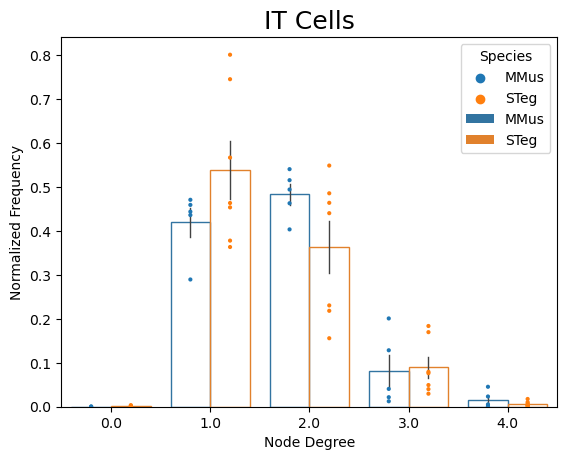

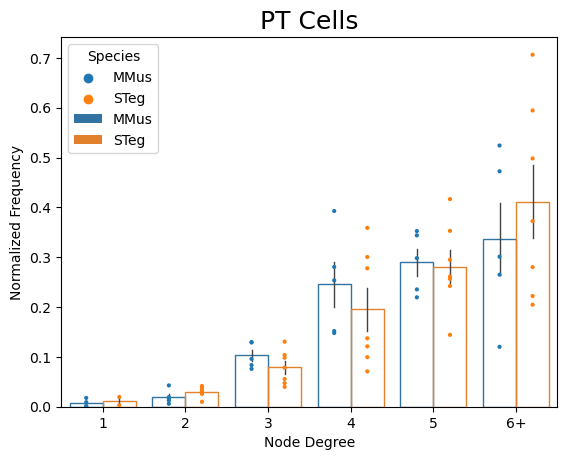

In [22]:
plot = pd.concat([mm_it_nodes, st_it_nodes])
dot_bar_plot(plot, "IT Cells")

# change node 6 to 6+
mm_pt_nodes_5and = node_to_nand(mm_pt_nodes)
st_pt_nodes_5and = node_to_nand(st_pt_nodes)

plot = pd.concat([mm_pt_nodes_5and, st_pt_nodes_5and])
dot_bar_plot(plot, "PT Cells")

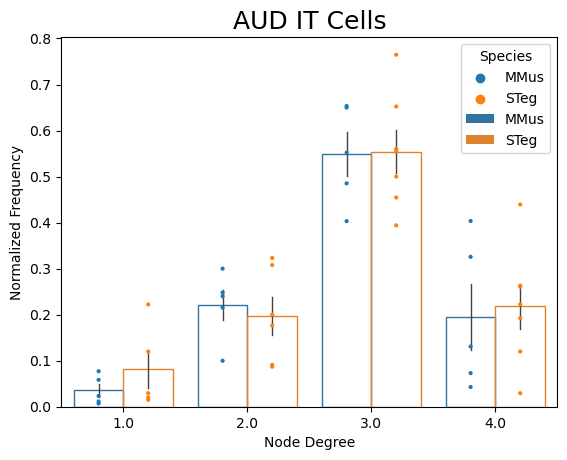

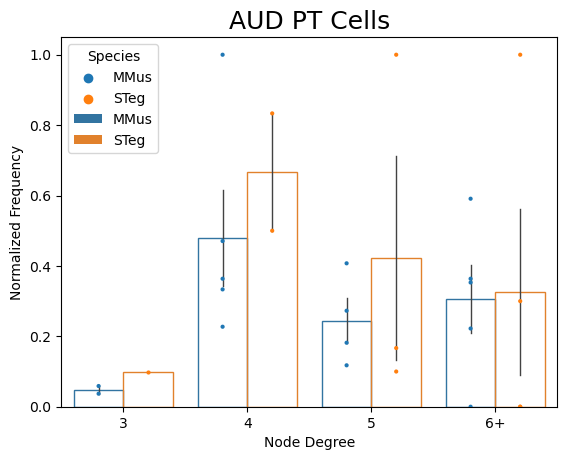

ACAi TO AUD NEURONS


,Species,Mouse,AUD neurons
0,STeg,STM1,0
1,STeg,STM2,10
2,STeg,STF3,0
3,STeg,STF4,0
4,STeg,STM5,1
5,STeg,STF6,6
6,STeg,STM7,1


,Species,Mouse,AUD neurons
0,MMus,MMM1,1
1,MMus,MMF2,17
2,MMus,MMF3,11
3,MMus,MMM4,27
4,MMus,MMF5,22


In [31]:
# seperate AUD neurons
aud_it_mm = subset_neurons(aca_it_mm)
aud_it_st = subset_neurons(aca_it_st)
aud_pt_mm = subset_neurons(aca_pt_mm)
aud_pt_st = subset_neurons(aca_pt_st)

# calculate degrees for aud cells
aud_mm_it_nodes = df_to_nodes(aud_it_mm, drop=["ACAi"], mice=mice_mm, species="MMus")
aud_st_it_nodes = df_to_nodes(aud_it_st, drop=["ACAi"], mice=mice_st, species="STeg")
aud_mm_pt_nodes = df_to_nodes(aud_pt_mm, drop=["ACAi"], mice=mice_mm, species="MMus")
aud_st_pt_nodes = df_to_nodes(aud_pt_st, drop=["ACAi"], mice=mice_st, species="STeg")

aud_mm_pt_nodes_5and = node_to_nand(aud_mm_pt_nodes)
aud_st_pt_nodes_5and = node_to_nand(aud_st_pt_nodes)
plot = pd.concat([aud_mm_it_nodes, aud_st_it_nodes])
dot_bar_plot(plot, "AUD IT Cells")
plot = pd.concat([aud_mm_pt_nodes_5and, aud_st_pt_nodes_5and])
dot_bar_plot(plot, "AUD PT Cells")

print('ACAi TO AUD NEURONS')
display(print_nums(aud_pt_st, species='STeg', mice=mice_st, area='AUD'))
display(print_nums(aud_pt_mm, area='AUD'))

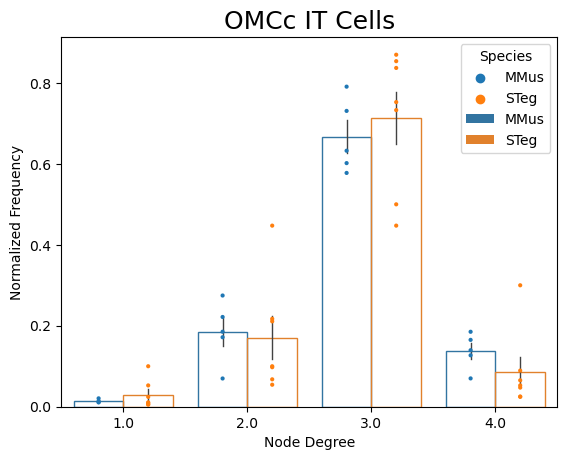

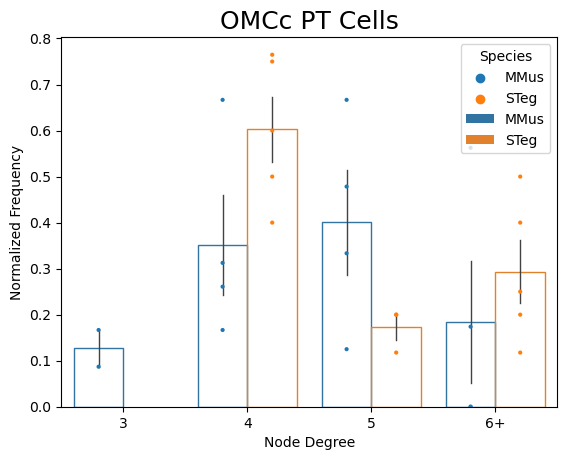

ACAi TO OMCc NEURONS


,Species,Mouse,OMCc neurons
0,STeg,STM1,0
1,STeg,STM2,17
2,STeg,STF3,4
3,STeg,STF4,0
4,STeg,STM5,8
5,STeg,STF6,5
6,STeg,STM7,5


,Species,Mouse,OMCc neurons
0,MMus,MMM1,0
1,MMus,MMF2,6
2,MMus,MMF3,3
3,MMus,MMM4,23
4,MMus,MMF5,16


In [32]:
# seperate OMCc neurons
omcc_it_mm = subset_neurons(aca_it_mm, area='OMCc')
omcc_it_st = subset_neurons(aca_it_st, area='OMCc')
omcc_pt_mm = subset_neurons(aca_pt_mm, area='OMCc')
omcc_pt_st = subset_neurons(aca_pt_st, area='OMCc')

# calculate degrees for omcc cells
omcc_mm_it_nodes = df_to_nodes(omcc_it_mm, drop=["ACAi"], mice=mice_mm, species="MMus")
omcc_st_it_nodes = df_to_nodes(omcc_it_st, drop=["ACAi"], mice=mice_st, species="STeg")
omcc_mm_pt_nodes = df_to_nodes(omcc_pt_mm, drop=["ACAi"], mice=mice_mm, species="MMus")
omcc_st_pt_nodes = df_to_nodes(omcc_pt_st, drop=["ACAi"], mice=mice_st, species="STeg")

omcc_mm_pt_nodes_5and = node_to_nand(omcc_mm_pt_nodes)
omcc_st_pt_nodes_5and = node_to_nand(omcc_st_pt_nodes)
plot = pd.concat([omcc_mm_it_nodes, omcc_st_it_nodes])
dot_bar_plot(plot, "OMCc IT Cells")
plot = pd.concat([omcc_mm_pt_nodes_5and, omcc_st_pt_nodes_5and])
dot_bar_plot(plot, "OMCc PT Cells")

print('ACAi TO OMCc NEURONS')
display(print_nums(omcc_pt_st, species='STeg', mice=mice_st, area='OMCc'))
display(print_nums(omcc_pt_mm, area='OMCc'))

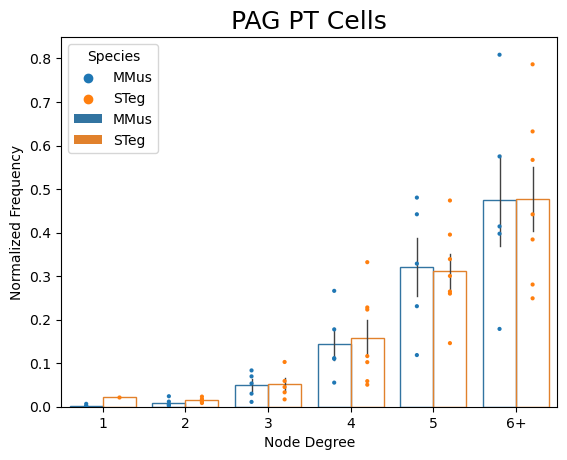

ACAi TO PAG NEURONS


,Species,Mouse,PAG neurons
0,STeg,STM1,57
1,STeg,STM2,354
2,STeg,STF3,253
3,STeg,STF4,43
4,STeg,STM5,272
5,STeg,STF6,178
6,STeg,STM7,254


,Species,Mouse,PAG neurons
0,MMus,MMM1,466
1,MMus,MMF2,2038
2,MMus,MMF3,2367
3,MMus,MMM4,632
4,MMus,MMF5,2863


In [33]:
# seperate PAG neurons - only find in pt neurons
pag_pt_mm = subset_neurons(aca_pt_mm, area='PAG')
pag_pt_st = subset_neurons(aca_pt_st, area='PAG')


# calculate degrees for pag cells
pag_mm_pt_nodes = df_to_nodes(pag_pt_mm, drop=["ACAi"], mice=mice_mm, species="MMus")
pag_st_pt_nodes = df_to_nodes(pag_pt_st, drop=["ACAi"], mice=mice_st, species="STeg")

pag_mm_pt_nodes_5and = node_to_nand(pag_mm_pt_nodes)
pag_st_pt_nodes_5and = node_to_nand(pag_st_pt_nodes)

# plot
plot = pd.concat([pag_mm_pt_nodes_5and, pag_st_pt_nodes_5and])
dot_bar_plot(plot, "PAG PT Cells")

print('ACAi TO PAG NEURONS')
display(print_nums(pag_pt_st, species='STeg', mice=mice_st, area='PAG'))
display(print_nums(pag_pt_mm, area='PAG'))

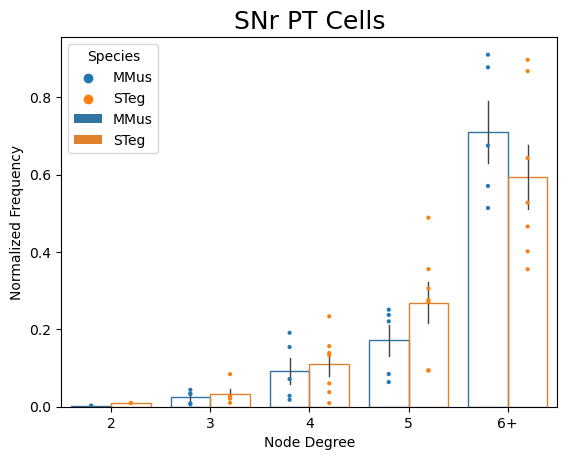

ACAi TO SNr NEURONS


,Species,Mouse,SNr neurons
0,STeg,STM1,45
1,STeg,STM2,236
2,STeg,STF3,107
3,STeg,STF4,36
4,STeg,STM5,106
5,STeg,STF6,107
6,STeg,STM7,199


,Species,Mouse,SNr neurons
0,MMus,MMM1,154
1,MMus,MMF2,1373
2,MMus,MMF3,251
3,MMus,MMM4,319
4,MMus,MMF5,1004


In [34]:
# seperate SNr neurons
snr_pt_mm = subset_neurons(aca_pt_mm, area='SNr')
snr_pt_st = subset_neurons(aca_pt_st, area='SNr')

# calculate degrees for snr cells
snr_mm_pt_nodes = df_to_nodes(snr_pt_mm, drop=["ACAi"], mice=mice_mm, species="MMus")
snr_st_pt_nodes = df_to_nodes(snr_pt_st, drop=["ACAi"], mice=mice_st, species="STeg")

snr_mm_pt_nodes_5and = node_to_nand(snr_mm_pt_nodes)
snr_st_pt_nodes_5and = node_to_nand(snr_st_pt_nodes)

plot = pd.concat([snr_mm_pt_nodes_5and, snr_st_pt_nodes_5and])
dot_bar_plot(plot, "SNr PT Cells")

print('ACAi TO SNr NEURONS')
display(print_nums(snr_pt_st, species='STeg', mice=mice_st, area='SNr'))
display(print_nums(snr_pt_mm, area='SNr'))